In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()  # Set the model to evaluation mode

Using cache found in /Users/nataliemolina/.cache/torch/hub/pytorch_vision_v0.10.0


## Functions

In [3]:
# Normalizing image
def preprocess_input(image):
    image = image / 255.0  
    return image

In [4]:
# Read image and segment fashion items with DeeplabV3

def segment_clothing(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Resize
    input_image = cv2.resize(original_image, (640,960))
    input_image = preprocess_input(input_image)

    # Convert to tensor, add batch dimension, and change type to float32
    input_image = torch.tensor(input_image).permute(2, 0, 1).unsqueeze(0).float() # permute rearranges the dimensions, unsqueeze adds a dimension
    
    # Segmentation
    with torch.no_grad():  # Disable gradient calculations
        predictions = model(input_image)
    segmentation_mask = torch.argmax(predictions["out"][0], dim=0).numpy() 

    # Create a mask for the fashion models (using class 15 for "person" in the Pascal VOC dataset)
    clothing_mask = (segmentation_mask == 15).astype(np.uint8)

    # Resize to original dimensions
    clothing_mask = cv2.resize(clothing_mask, (original_image.shape[1], original_image.shape[0]))

    # Apply mask
    segmented_image = cv2.bitwise_and(original_image, original_image, mask=clothing_mask)

    return original_image, segmented_image


In [5]:
# Color extraction
def extract_dominant_colors(segmented_image, num_colors=5):
    
    # Reshape  to 2D array of pixels
    pixel_values = segmented_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values) 

    # Remove background (black pixels)
    pixel_values = pixel_values[~np.all(pixel_values == [0, 0, 0], axis=1)] 

    # K-Means clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixel_values)
    
    # Get the dominant colors
    dominant_colors = kmeans.cluster_centers_
    dominant_colors = np.round(dominant_colors).astype(int)

    return dominant_colors

In [6]:
# Making sure that shades that are too similiar count as one
# You can change the threshold to your preference
def are_colors_similar(color1, color2, threshold=50):
    return np.all(np.abs(np.array(color1) - np.array(color2)) <= threshold)

In [7]:
# Results and visualization
def extract_dominant_colors_from_clothing(image_path, color_count_dict, num_colors=5):
    # Segment the clothing
    original_image, segmented_image = segment_clothing(image_path)

    # Extract dominant colors
    dominant_colors = extract_dominant_colors(segmented_image, num_colors)

    # Count color similarities
    for color in dominant_colors:
        color_tuple = tuple(color)
        for existing_color in color_count_dict.keys():
            if are_colors_similar(existing_color, color_tuple):
                color_count_dict[existing_color] += 1
                break  # Stop checking once a similar color is found
        else:
            color_count_dict[color_tuple] = 1  # Add the new color if not found

    # Display the original image, segmented image, and color palette
    # Adapt the size of the palette depending on the number of colors you are looking for
    # 5 colors = 100,300
    # 4 colors = 100, 240
    # 3 colors = 100, 180
    # 2 colors = 100,120
    # 1 color = 100,60
    palette = np.zeros((100, 120, 3), dtype=np.uint8)
    for i in range(num_colors):
        palette[:, i * 60:(i + 1) * 60] = dominant_colors[i]

# The following is not mandatory, you can comment the code below if you are not interested in this visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.title('Segmented Clothing Image')

    plt.subplot(1, 3, 3)
    plt.imshow(palette)
    plt.axis('off')
    plt.title('Dominant Colors')
    
    plt.show()


In [8]:
# RGB to HEX conversion
color_codes = []
def rgb_to_hex(rgb_list):
    for rgb_code in rgb_list:
        rgb_code = rgb_code.replace("(", "").replace(")","")

        r, g, b = map(int,rgb_code.split(","))

        hex_code = f"#{r:02X}{g:02X}{b:02X}"
        
        color_codes.append(hex_code)
    return 

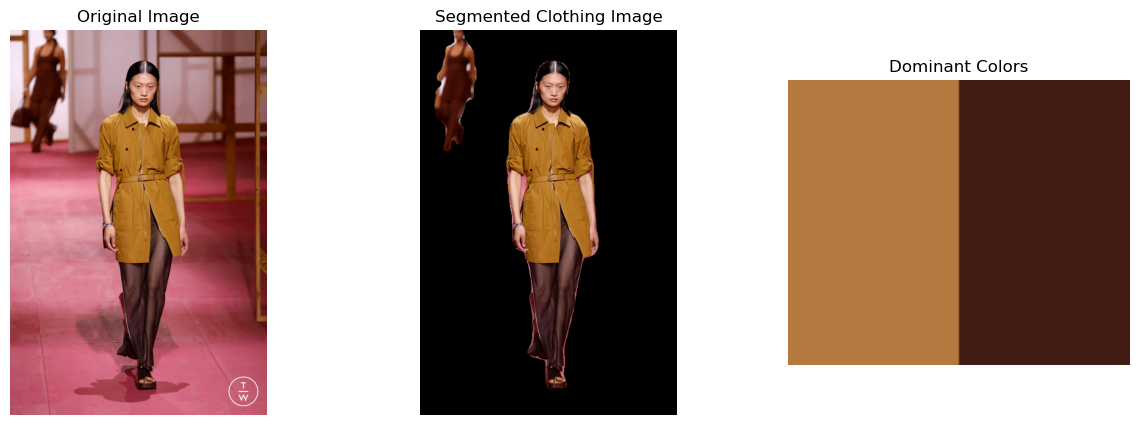

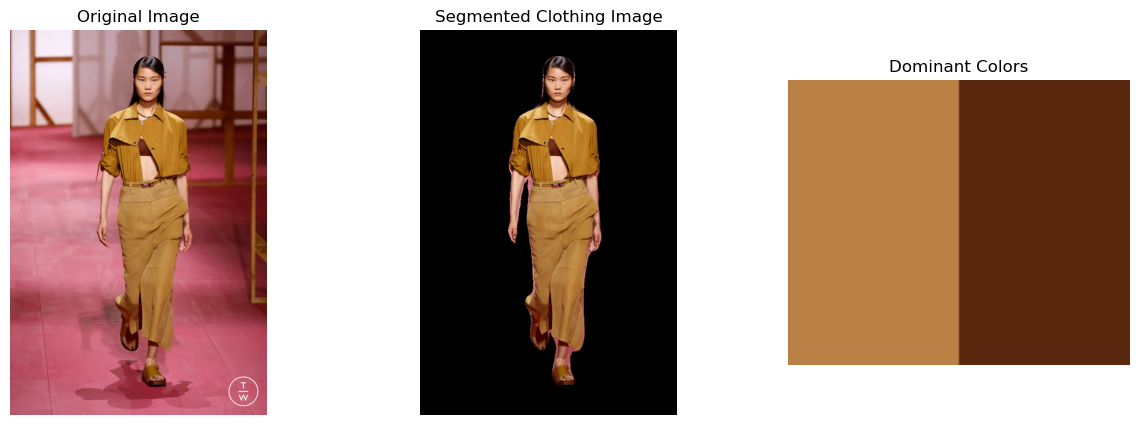

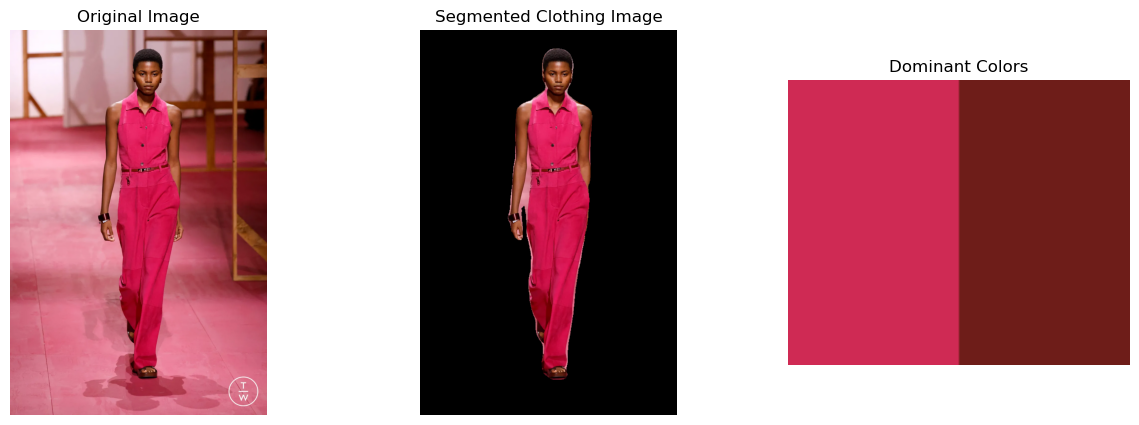

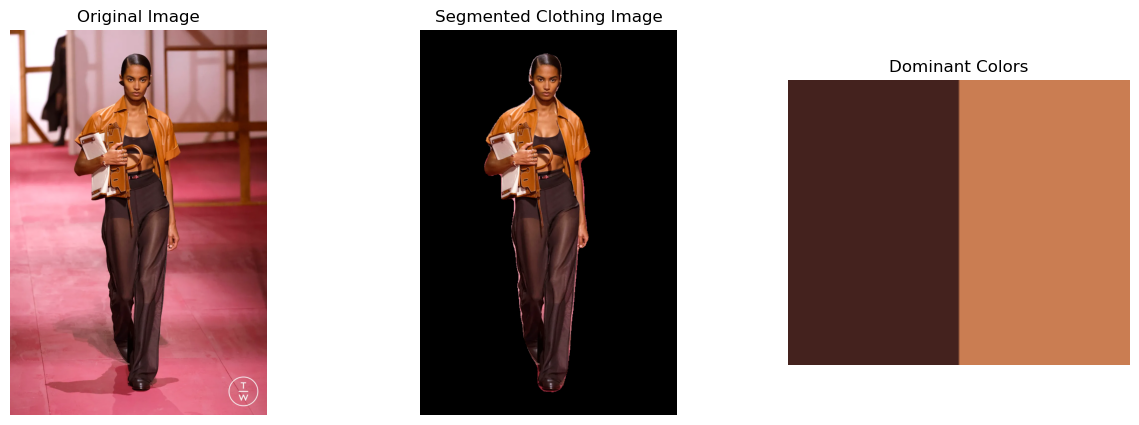

In [9]:
# Color count dictionary
color_count = {}

# Count
image_paths = ['./data/hermes1.jpg', './data/hermes2.jpg', './data/hermes3.jpg', './data/hermes4.jpg']

for image_path in image_paths:
    extract_dominant_colors_from_clothing(image_path, color_count, num_colors=2)

In [10]:
def bar_chart(keys, values, color = color_codes):
    plt.bar(keys,values, color = color_codes)
    plt.title('Color Count')
    plt.xticks([])
    plt.yticks(range(min(values), max(values) + 1))
    # Saving chart
    plt.savefig('colorcount_barchart.png', format='png')
    plt.show();

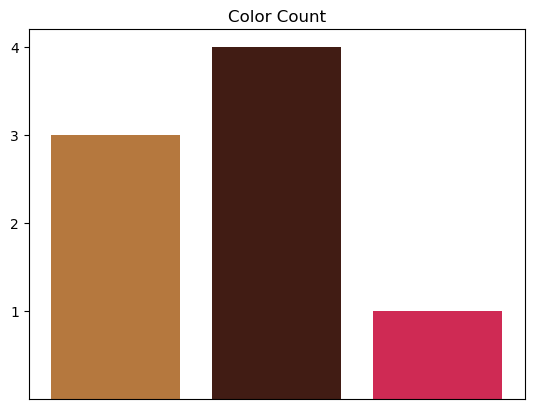

In [11]:
# Bar Chart: 
# First, turning the dictionary keys and values into lists
keys = [str(key) for key in color_count.keys()]
values = list(color_count.values())

# Transforming the RGB numbers to HEX codes
rgb_to_hex(keys)

bar_chart(keys,values, color_codes)
